In [7]:
import pandas as pd
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
np.random.seed(42)

## Question 1
Find the effect in dataset 12.1, given that Group = 1 is the treatment group and Time > 0 is the treatment time.

In [8]:
df = pd.read_csv('homework_12.1.csv', index_col=0)
df.head()

,Y,Time,Group
0,-0.232900,-1.193204,0
1,2.848846,-1.607748,1
2,0.550209,-0.269793,0
3,2.198280,7.743730,0
4,4.111044,-4.244359,1


DIFFERENCE-IN-DIFFERENCES ANALYSIS
Dataset shape: (10000, 3)

First few rows:
          Y      Time  Group
0 -0.232900 -1.193204      0
1  2.848846 -1.607748      1
2  0.550209 -0.269793      0
3  2.198280  7.743730      0
4  4.111044 -4.244359      1

Basic statistics:
                  Y          Time         Group
count  10000.000000  10000.000000  10000.000000
mean       2.233833      0.033799      0.194300
std        1.665661      5.775950      0.395681
min       -2.422275     -9.999271      0.000000
25%        1.061957     -4.995114      0.000000
50%        2.073258      0.085758      0.000000
75%        3.150351      5.050668      0.000000
max        8.485857      9.996859      1.000000
Treatment distribution:
treated
0    8057
1    1943
Name: count, dtype: int64

Time period distribution:
post
1    5040
0    4960
Name: count, dtype: int64

Cross-tabulation of treatment and time:
post        0     1    All
treated                   
0        4016  4041   8057
1         944   999

/var/folders/4k/nl2zz_ln4d55dcscl_vvjglh0000gn/T/ipykernel_25861/1005865635.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trends = pre_treatment.groupby(['treated', 'time_bin'])['Y'].mean().unstack()


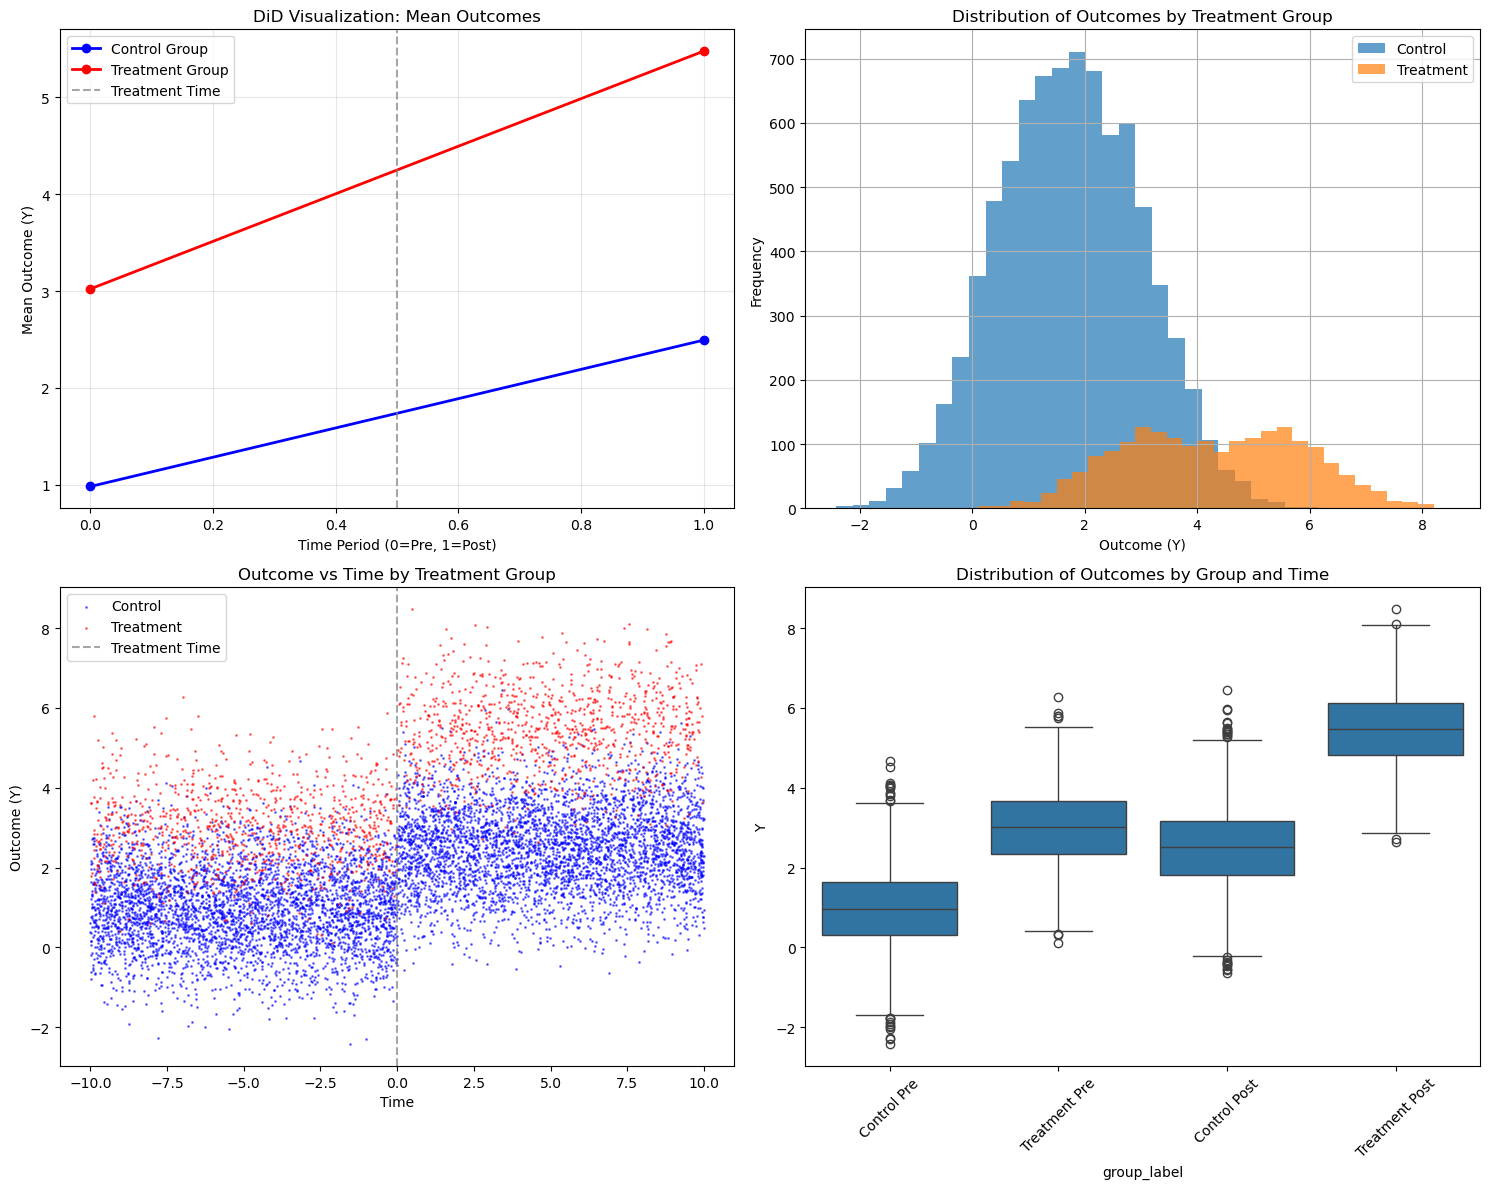


SUMMARY OF RESULTS
Treatment Effect (DiD Coefficient): 0.9440
Statistical Significance: p = 0.0000
✓ The treatment effect is statistically significant at 5% level
✓ The treatment has a positive effect on the outcome

Interpretation:
The treatment (Group=1) in the post-treatment period (Time>0)
leads to a change in outcome Y of 0.9440 units compared to
what would have happened without the treatment.

EFFECT SIZE ANALYSIS
Effect size (Cohen's d): 0.9448
Effect magnitude: large


In [9]:
# instrumental variable regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler

# Load the dataset
def load_data(filepath):
    """Load and prepare the dataset for DiD analysis"""
    df = pd.read_csv(filepath)
    
    # Remove the unnamed index column if it exists
    if df.columns[0] == '' or 'Unnamed' in df.columns[0]:
        df = df.drop(df.columns[0], axis=1)
    
    print("Dataset shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())
    print("\nBasic statistics:")
    print(df.describe())
    
    return df

# Prepare DiD variables
def prepare_did_variables(df):
    """Create treatment and post-treatment indicator variables"""
    # Treatment group indicator (Group = 1 is treatment)
    df['treated'] = (df['Group'] == 1).astype(int)
    
    # Post-treatment period indicator (Time > 0 is post-treatment)
    df['post'] = (df['Time'] > 0).astype(int)
    
    # Interaction term for DiD estimator
    df['treated_post'] = df['treated'] * df['post']
    
    print("Treatment distribution:")
    print(df['treated'].value_counts())
    print("\nTime period distribution:")
    print(df['post'].value_counts())
    print("\nCross-tabulation of treatment and time:")
    print(pd.crosstab(df['treated'], df['post'], margins=True))
    
    return df

# Descriptive statistics by groups
def descriptive_analysis(df):
    """Provide descriptive statistics for DiD analysis"""
    
    # Create group labels for clarity
    df['group_label'] = df.apply(lambda x: 
        'Control Pre' if x['treated'] == 0 and x['post'] == 0 else
        'Control Post' if x['treated'] == 0 and x['post'] == 1 else
        'Treatment Pre' if x['treated'] == 1 and x['post'] == 0 else
        'Treatment Post', axis=1)
    
    # Summary statistics by group
    group_stats = df.groupby(['treated', 'post'])['Y'].agg(['count', 'mean', 'std']).round(4)
    print("Summary statistics by group:")
    print(group_stats)
    
    # Mean outcomes by group for DiD calculation
    means = df.groupby(['treated', 'post'])['Y'].mean()
    
    # Manual DiD calculation
    control_pre = means[(0, 0)]
    control_post = means[(0, 1)]
    treatment_pre = means[(1, 0)]
    treatment_post = means[(1, 1)]
    
    # Difference-in-differences calculation
    control_diff = control_post - control_pre
    treatment_diff = treatment_post - treatment_pre
    did_effect = treatment_diff - control_diff
    
    print(f"\nManual DiD Calculation:")
    print(f"Control group change: {control_diff:.4f}")
    print(f"Treatment group change: {treatment_diff:.4f}")
    print(f"Difference-in-Differences effect: {did_effect:.4f}")
    
    return group_stats, did_effect

# DiD Regression Model
def did_regression(df):
    """Estimate DiD model using OLS regression"""
    
    # Basic DiD regression: Y = β0 + β1*treated + β2*post + β3*treated*post + ε
    model_basic = ols('Y ~ treated + post + treated_post', data=df).fit()
    
    print("=== BASIC DiD REGRESSION RESULTS ===")
    print(model_basic.summary())
    
    # Extract the DiD coefficient (interaction term)
    did_coefficient = model_basic.params['treated_post']
    did_se = model_basic.bse['treated_post']
    did_tstat = model_basic.tvalues['treated_post']
    did_pvalue = model_basic.pvalues['treated_post']
    
    # Confidence interval
    conf_int = model_basic.conf_int().loc['treated_post']
    
    print(f"\n=== DiD TREATMENT EFFECT ===")
    print(f"Coefficient: {did_coefficient:.4f}")
    print(f"Standard Error: {did_se:.4f}")
    print(f"t-statistic: {did_tstat:.4f}")
    print(f"p-value: {did_pvalue:.4f}")
    print(f"95% Confidence Interval: [{conf_int[0]:.4f}, {conf_int[1]:.4f}]")
    
    # Statistical significance
    if did_pvalue < 0.001:
        significance = "***"
    elif did_pvalue < 0.01:
        significance = "**"
    elif did_pvalue < 0.05:
        significance = "*"
    elif did_pvalue < 0.1:
        significance = "."
    else:
        significance = ""
    
    print(f"Significance: {significance}")
    print("(*** p<0.001, ** p<0.01, * p<0.05, . p<0.1)")
    
    return model_basic, did_coefficient, did_pvalue

# Extended DiD model with controls
def did_regression_extended(df):
    """Extended DiD model with time as a control variable"""
    
    # Add Time as a control variable
    model_extended = ols('Y ~ treated + post + treated_post + Time', data=df).fit()
    
    print("\n=== EXTENDED DiD REGRESSION WITH TIME CONTROL ===")
    print(model_extended.summary())
    
    return model_extended

# Parallel trends assumption check
def check_parallel_trends(df):
    """Check parallel trends assumption using pre-treatment data"""
    
    # Filter pre-treatment data
    pre_treatment = df[df['post'] == 0].copy()
    
    if len(pre_treatment) > 0:
        # Create time bins for pre-treatment period
        pre_treatment['time_bin'] = pd.qcut(pre_treatment['Time'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        
        # Calculate mean Y by treatment group and time bin
        trends = pre_treatment.groupby(['treated', 'time_bin'])['Y'].mean().unstack()
        
        print("\n=== PARALLEL TRENDS CHECK (Pre-treatment Period) ===")
        print("Mean outcomes by treatment group and time quartile:")
        print(trends)
        
        # Test for parallel trends (interaction between treatment and time in pre-period)
        if len(pre_treatment['Time'].unique()) > 10:  # Only if sufficient time variation
            trend_model = ols('Y ~ treated * Time', data=pre_treatment).fit()
            interaction_pvalue = trend_model.pvalues.get('treated:Time', None)
            
            if interaction_pvalue is not None:
                print(f"\nParallel trends test (pre-treatment):")
                print(f"Interaction p-value: {interaction_pvalue:.4f}")
                if interaction_pvalue > 0.05:
                    print("✓ Parallel trends assumption appears to hold (p > 0.05)")
                else:
                    print("⚠ Parallel trends assumption may be violated (p ≤ 0.05)")
    else:
        print("No pre-treatment data available for parallel trends test")

# Robustness checks
def robustness_checks(df):
    """Perform various robustness checks"""
    
    print("\n=== ROBUSTNESS CHECKS ===")
    
    # 1. DiD with different time cutoffs
    time_cutoffs = [-1, -0.5, 0.5, 1]
    
    print("1. Sensitivity to time cutoff:")
    for cutoff in time_cutoffs:
        df_temp = df.copy()
        df_temp['post_alt'] = (df_temp['Time'] > cutoff).astype(int)
        df_temp['treated_post_alt'] = df_temp['treated'] * df_temp['post_alt']
        
        model_alt = ols('Y ~ treated + post_alt + treated_post_alt', data=df_temp).fit()
        did_coef = model_alt.params['treated_post_alt']
        did_pval = model_alt.pvalues['treated_post_alt']
        
        print(f"  Cutoff at {cutoff}: {did_coef:.4f} (p={did_pval:.4f})")
    
    # 2. Exclude observations near the cutoff
    print("\n2. Excluding observations near time cutoff:")
    for window in [0.1, 0.2, 0.5]:
        df_filtered = df[abs(df['Time']) > window].copy()
        
        if len(df_filtered) > 100:  # Ensure sufficient observations
            model_filtered = ols('Y ~ treated + post + treated_post', data=df_filtered).fit()
            did_coef = model_filtered.params['treated_post']
            did_pval = model_filtered.pvalues['treated_post']
            
            print(f"  Excluding |Time| ≤ {window}: {did_coef:.4f} (p={did_pval:.4f}), N={len(df_filtered)}")

# Visualization
def create_visualizations(df):
    """Create visualizations for DiD analysis"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Mean outcomes by group and time
    group_means = df.groupby(['treated', 'post'])['Y'].mean().unstack()
    
    axes[0,0].plot([0, 1], [group_means.loc[0, 0], group_means.loc[0, 1]], 
                   'b-o', linewidth=2, label='Control Group')
    axes[0,0].plot([0, 1], [group_means.loc[1, 0], group_means.loc[1, 1]], 
                   'r-o', linewidth=2, label='Treatment Group')
    axes[0,0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Treatment Time')
    axes[0,0].set_xlabel('Time Period (0=Pre, 1=Post)')
    axes[0,0].set_ylabel('Mean Outcome (Y)')
    axes[0,0].set_title('DiD Visualization: Mean Outcomes')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Distribution of outcomes by treatment group
    df[df['treated'] == 0]['Y'].hist(alpha=0.7, bins=30, label='Control', ax=axes[0,1])
    df[df['treated'] == 1]['Y'].hist(alpha=0.7, bins=30, label='Treatment', ax=axes[0,1])
    axes[0,1].set_xlabel('Outcome (Y)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of Outcomes by Treatment Group')
    axes[0,1].legend()
    
    # 3. Scatter plot: Time vs Outcome
    control = df[df['treated'] == 0]
    treatment = df[df['treated'] == 1]
    
    axes[1,0].scatter(control['Time'], control['Y'], alpha=0.5, c='blue', label='Control', s=1)
    axes[1,0].scatter(treatment['Time'], treatment['Y'], alpha=0.5, c='red', label='Treatment', s=1)
    axes[1,0].axvline(x=0, color='gray', linestyle='--', alpha=0.7, label='Treatment Time')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Outcome (Y)')
    axes[1,0].set_title('Outcome vs Time by Treatment Group')
    axes[1,0].legend()
    
    # 4. Box plot by group
    df['group_label'] = df.apply(lambda x: 
        'Control Pre' if x['treated'] == 0 and x['post'] == 0 else
        'Control Post' if x['treated'] == 0 and x['post'] == 1 else
        'Treatment Pre' if x['treated'] == 1 and x['post'] == 0 else
        'Treatment Post', axis=1)
    
    sns.boxplot(data=df, x='group_label', y='Y', ax=axes[1,1])
    axes[1,1].set_title('Distribution of Outcomes by Group and Time')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Main analysis function
def main_analysis(filepath='homework_12.1.csv'):
    """Main function to run complete DiD analysis"""
    
    print("=" * 60)
    print("DIFFERENCE-IN-DIFFERENCES ANALYSIS")
    print("=" * 60)
    
    # Load data
    df = load_data(filepath)
    
    # Prepare DiD variables
    df = prepare_did_variables(df)
    
    # Descriptive analysis
    print("\n" + "=" * 60)
    print("DESCRIPTIVE ANALYSIS")
    print("=" * 60)
    group_stats, manual_did = descriptive_analysis(df)
    
    # DiD regression
    print("\n" + "=" * 60)
    print("REGRESSION ANALYSIS")
    print("=" * 60)
    model_basic, did_coef, did_pval = did_regression(df)
    
    # Extended model
    model_extended = did_regression_extended(df)
    
    # Assumption checks
    print("\n" + "=" * 60)
    print("ASSUMPTION CHECKS")
    print("=" * 60)
    check_parallel_trends(df)
    
    # Robustness checks
    robustness_checks(df)
    
    # Create visualizations
    print("\n" + "=" * 60)
    print("VISUALIZATIONS")
    print("=" * 60)
    create_visualizations(df)
    
    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY OF RESULTS")
    print("=" * 60)
    print(f"Treatment Effect (DiD Coefficient): {did_coef:.4f}")
    print(f"Statistical Significance: p = {did_pval:.4f}")
    
    if did_pval < 0.05:
        print("✓ The treatment effect is statistically significant at 5% level")
        if did_coef > 0:
            print("✓ The treatment has a positive effect on the outcome")
        else:
            print("✓ The treatment has a negative effect on the outcome")
    else:
        print("⚠ The treatment effect is not statistically significant at 5% level")
    
    print(f"\nInterpretation:")
    print(f"The treatment (Group=1) in the post-treatment period (Time>0)")
    print(f"leads to a change in outcome Y of {did_coef:.4f} units compared to")
    print(f"what would have happened without the treatment.")
    
    return df, model_basic, model_extended

# Run the analysis
if __name__ == "__main__":
    # Run the complete analysis
    df, basic_model, extended_model = main_analysis()
    
    # Additional analysis: Effect size
    print("\n" + "=" * 60)
    print("EFFECT SIZE ANALYSIS")
    print("=" * 60)
    
    # Calculate effect size (Cohen's d)
    control_pre = df[(df['treated'] == 0) & (df['post'] == 0)]['Y']
    treatment_post = df[(df['treated'] == 1) & (df['post'] == 1)]['Y']
    
    pooled_std = np.sqrt(((len(control_pre) - 1) * control_pre.var() + 
                         (len(treatment_post) - 1) * treatment_post.var()) / 
                        (len(control_pre) + len(treatment_post) - 2))
    
    effect_size = abs(basic_model.params['treated_post']) / pooled_std
    
    print(f"Effect size (Cohen's d): {effect_size:.4f}")
    
    if effect_size < 0.2:
        magnitude = "small"
    elif effect_size < 0.5:
        magnitude = "small to medium"
    elif effect_size < 0.8:
        magnitude = "medium to large"
    else:
        magnitude = "large"
    
    print(f"Effect magnitude: {magnitude}")

DIFFERENCE-IN-DIFFERENCES ANALYSIS
Dataset shape: (10000, 3)

First few rows:
          Y      Time  Group
0 -0.232900 -1.193204      0
1  2.848846 -1.607748      1
2  0.550209 -0.269793      0
3  2.198280  7.743730      0
4  4.111044 -4.244359      1

Basic statistics:
                  Y          Time         Group
count  10000.000000  10000.000000  10000.000000
mean       2.233833      0.033799      0.194300
std        1.665661      5.775950      0.395681
min       -2.422275     -9.999271      0.000000
25%        1.061957     -4.995114      0.000000
50%        2.073258      0.085758      0.000000
75%        3.150351      5.050668      0.000000
max        8.485857      9.996859      1.000000
Treatment distribution:
treated
0    8057
1    1943
Name: count, dtype: int64

Time period distribution:
post
1    5040
0    4960
Name: count, dtype: int64

Cross-tabulation of treatment and time:
post        0     1    All
treated                   
0        4016  4041   8057
1         944   999

/var/folders/4k/nl2zz_ln4d55dcscl_vvjglh0000gn/T/ipykernel_25861/1005865635.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trends = pre_treatment.groupby(['treated', 'time_bin'])['Y'].mean().unstack()


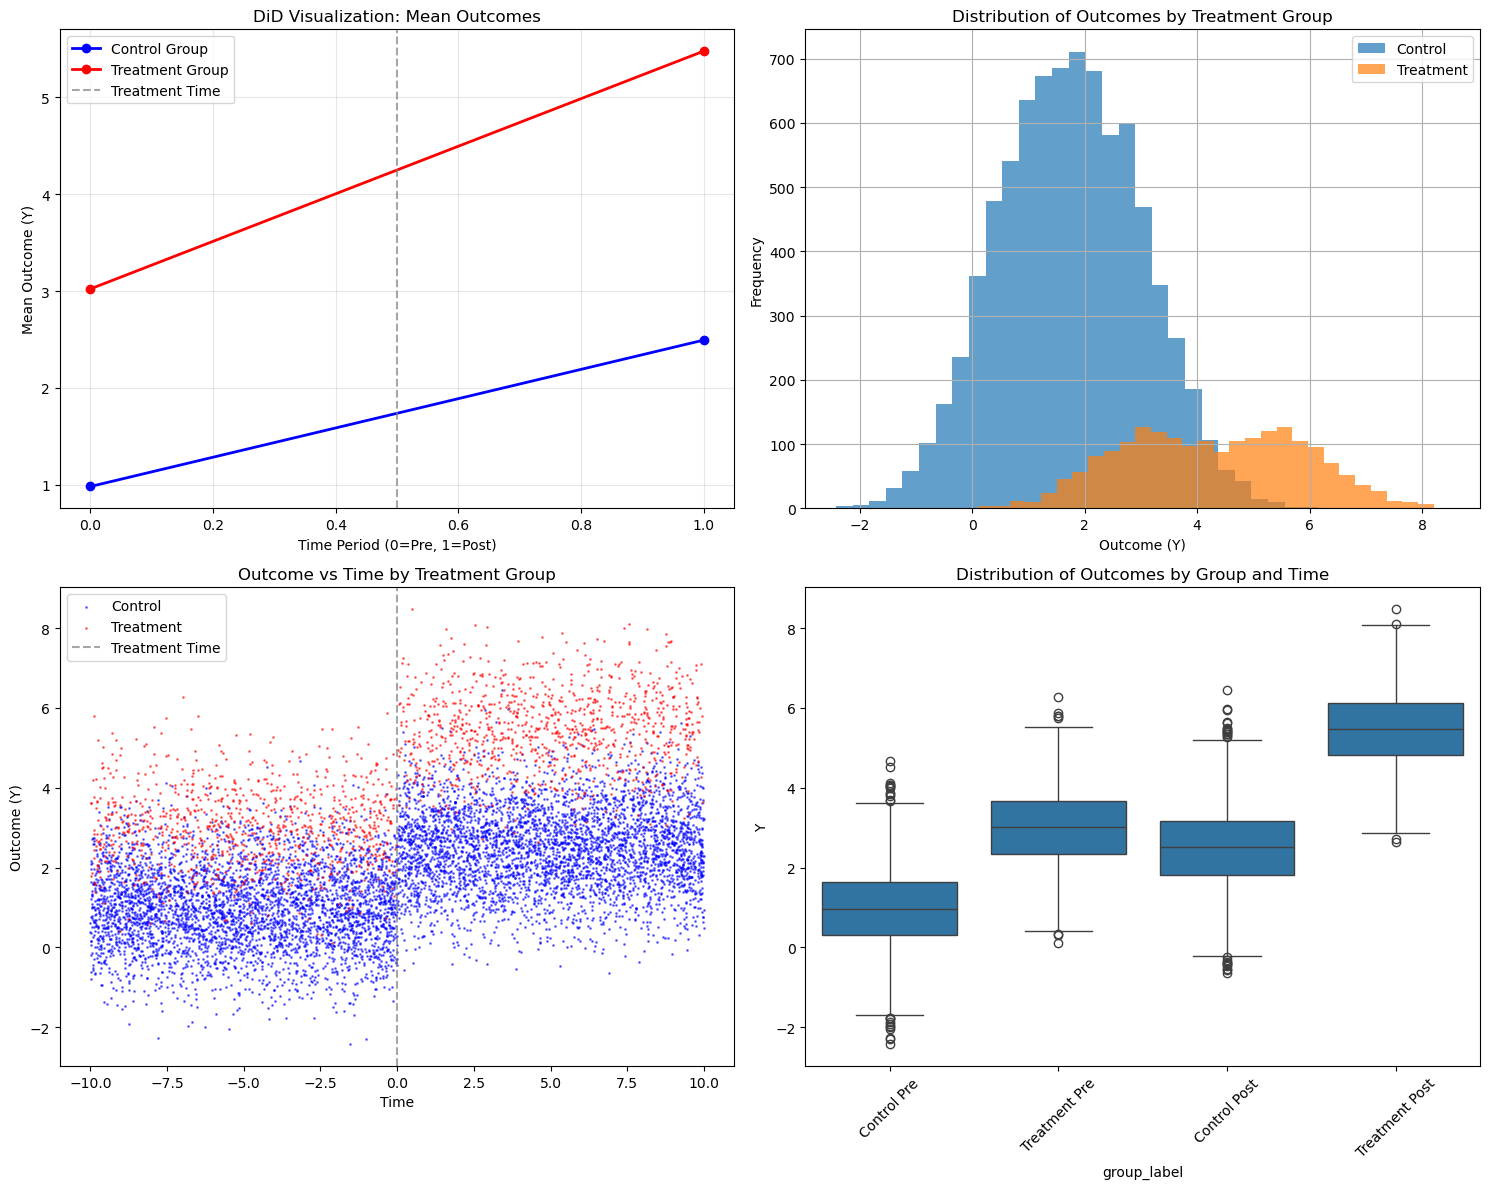


SUMMARY OF RESULTS
Treatment Effect (DiD Coefficient): 0.9440
Statistical Significance: p = 0.0000
✓ The treatment effect is statistically significant at 5% level
✓ The treatment has a positive effect on the outcome

Interpretation:
The treatment (Group=1) in the post-treatment period (Time>0)
leads to a change in outcome Y of 0.9440 units compared to
what would have happened without the treatment.
Treatment Effect: 0.9440
P-value: 0.0000


In [10]:
# Basic usage - just run the main analysis
df, basic_model, extended_model = main_analysis('homework_12.1.csv')

# The DiD treatment effect is the coefficient on 'treated_post'
treatment_effect = basic_model.params['treated_post']
p_value = basic_model.pvalues['treated_post']

print(f"Treatment Effect: {treatment_effect:.4f}")
print(f"P-value: {p_value:.4f}")

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(0) 
X1 = np.random.normal(0, 1, 1000) 
X2 = np.random.normal(0, 1, 1000) + X1 
X3 = np.random.normal(0, 1, 1000) + 2 * X2 

# find the vif for each variable
X = np.column_stack((X1, X2, X3))
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print("Variance Inflation Factors (VIF):")
for i, v in enumerate(vif):
    print(f"X{i+1}: {v:.4f}")

Variance Inflation Factors (VIF):
X1: 1.9789
X2: 10.0834
X3: 8.9759


PARALLEL TRENDS TEST FOR DATASET 12.2
Dataset 12.2 Overview:
Total observations: 20000
Columns: ['Y', 'Time', 'Group']
Time range: -9.9994 to 9.9986
Groups: [0, 1]

Pre-treatment data:
Observations with Time < 0: 9944
Pre-treatment time range: -9.9994 to -0.0011
Group distribution in pre-treatment period:
  Group 0: 7999 observations
  Group 1: 1945 observations

PARALLEL TRENDS TEST
Model: Y ~ Group + Time + Group:Time
Testing H₀: β₃ = 0 (parallel trends)
Testing H₁: β₃ ≠ 0 (non-parallel trends)

Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     1591.
Date:                Sat, 09 Aug 2025   Prob (F-statistic):               0.00
Time:                        20:26:18   Log-Likelihood:                -13981.
No.

/var/folders/4k/nl2zz_ln4d55dcscl_vvjglh0000gn/T/ipykernel_25861/182123814.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = pre_treatment_data.groupby(['time_bin', 'Group'])['Y'].mean().unstack()
/var/folders/4k/nl2zz_ln4d55dcscl_vvjglh0000gn/T/ipykernel_25861/182123814.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means_full = df.groupby(['time_bin', 'Group'])['Y'].mean().unstack()


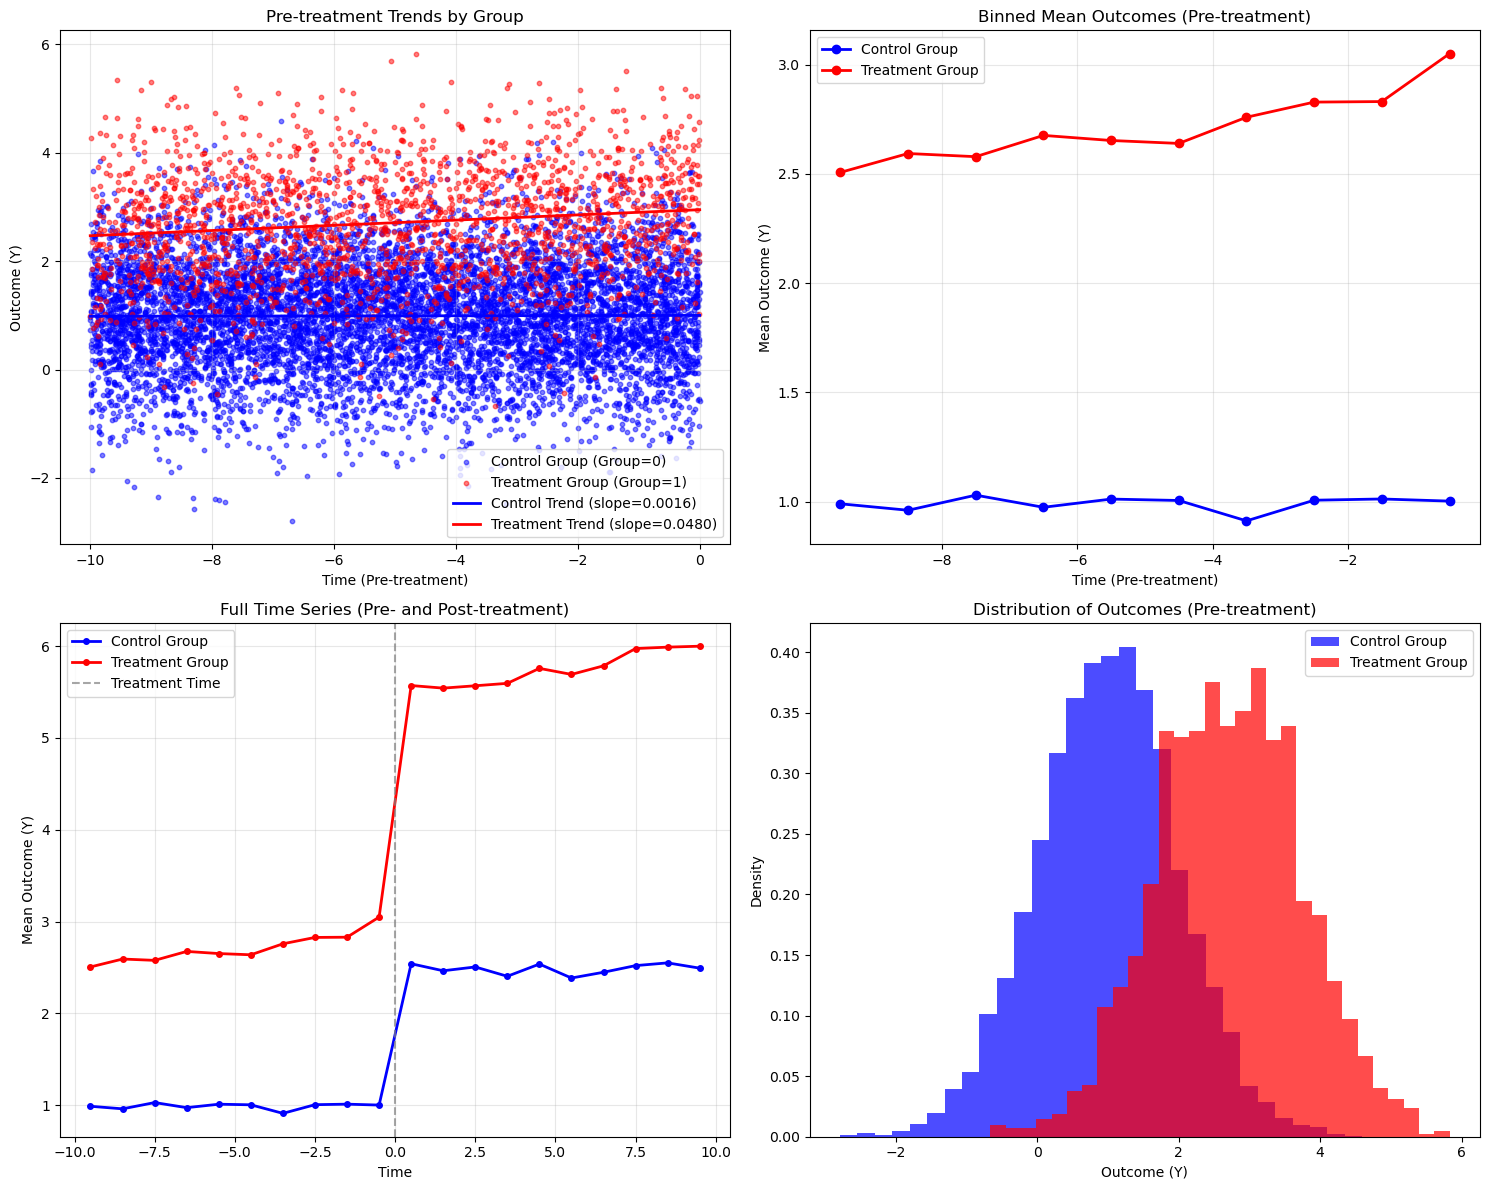


FINAL SUMMARY
t-value of Group × Time interaction: 5.329380
p-value: 0.000000
Conclusion: STRONG evidence against parallel trends (|t| ≥ 2.58)

🎯 ANSWER: The t-value of the Group × Time interaction term is: 5.329380


In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data(filepath='homework_12.2.csv'):
    """Load dataset 12.2 and prepare for parallel trends test"""
    
    # Load the data
    df = pd.read_csv(filepath)
    
    # Remove the unnamed index column if it exists
    if df.columns[0] == '' or 'Unnamed' in df.columns[0]:
        df = df.drop(df.columns[0], axis=1)
    
    print("Dataset 12.2 Overview:")
    print(f"Total observations: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print(f"Time range: {df['Time'].min():.4f} to {df['Time'].max():.4f}")
    print(f"Groups: {sorted(df['Group'].unique())}")
    
    # Filter for pre-treatment period (Time < 0)
    pre_treatment = df[df['Time'] < 0].copy()
    
    print(f"\nPre-treatment data:")
    print(f"Observations with Time < 0: {len(pre_treatment)}")
    print(f"Pre-treatment time range: {pre_treatment['Time'].min():.4f} to {pre_treatment['Time'].max():.4f}")
    
    # Group distribution in pre-treatment period
    group_counts = pre_treatment['Group'].value_counts().sort_index()
    print(f"Group distribution in pre-treatment period:")
    for group, count in group_counts.items():
        print(f"  Group {group}: {count} observations")
    
    return df, pre_treatment

def run_parallel_trends_test(pre_treatment_data):
    """
    Run parallel trends test using linear regression with Group × Time interaction
    
    Model: Y = β₀ + β₁×Group + β₂×Time + β₃×(Group×Time) + ε
    
    The coefficient β₃ tests whether the treatment and control groups
    have different pre-treatment trends. If β₃ is significant, it suggests
    violation of the parallel trends assumption.
    """
    
    print("\n" + "="*60)
    print("PARALLEL TRENDS TEST")
    print("="*60)
    print("Model: Y ~ Group + Time + Group:Time")
    print("Testing H₀: β₃ = 0 (parallel trends)")
    print("Testing H₁: β₃ ≠ 0 (non-parallel trends)")
    
    # Create interaction term
    pre_treatment_data = pre_treatment_data.copy()
    pre_treatment_data['Group_Time'] = pre_treatment_data['Group'] * pre_treatment_data['Time']
    
    # Fit the regression model
    # Y = β₀ + β₁×Group + β₂×Time + β₃×(Group×Time) + ε
    model = ols('Y ~ Group + Time + Group:Time', data=pre_treatment_data).fit()
    
    print("\nRegression Results:")
    print(model.summary())
    
    # Extract key statistics for the interaction term
    interaction_coef = model.params['Group:Time']
    interaction_se = model.bse['Group:Time']
    interaction_tvalue = model.tvalues['Group:Time']
    interaction_pvalue = model.pvalues['Group:Time']
    
    print(f"\n" + "="*60)
    print("PARALLEL TRENDS TEST RESULTS")
    print("="*60)
    print(f"Interaction coefficient (β₃): {interaction_coef:.6f}")
    print(f"Standard error: {interaction_se:.6f}")
    print(f"t-value: {interaction_tvalue:.6f}")
    print(f"p-value: {interaction_pvalue:.6f}")
    
    # Confidence interval
    conf_int = model.conf_int().loc['Group:Time']
    print(f"95% Confidence Interval: [{conf_int[0]:.6f}, {conf_int[1]:.6f}]")
    
    # Interpretation
    print(f"\nInterpretation:")
    if interaction_pvalue < 0.05:
        print("❌ PARALLEL TRENDS ASSUMPTION VIOLATED (p < 0.05)")
        print("   The treatment and control groups have significantly different pre-treatment trends.")
        print("   DiD estimates may be biased.")
    else:
        print("✅ PARALLEL TRENDS ASSUMPTION HOLDS (p ≥ 0.05)")
        print("   No evidence of different pre-treatment trends between groups.")
        print("   DiD approach is appropriate.")
    
    # Effect size
    print(f"\nEffect size analysis:")
    mean_y = pre_treatment_data['Y'].mean()
    relative_effect = abs(interaction_coef) / mean_y * 100
    print(f"Interaction effect relative to mean Y: {relative_effect:.2f}%")
    
    return model, interaction_tvalue, interaction_pvalue

def visualize_trends(df, pre_treatment_data):
    """Create visualizations to assess parallel trends"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Pre-treatment trends by group
    control_pre = pre_treatment_data[pre_treatment_data['Group'] == 0]
    treatment_pre = pre_treatment_data[pre_treatment_data['Group'] == 1]
    
    # Scatter plot of pre-treatment trends
    axes[0, 0].scatter(control_pre['Time'], control_pre['Y'], alpha=0.5, 
                      color='blue', label='Control Group (Group=0)', s=10)
    axes[0, 0].scatter(treatment_pre['Time'], treatment_pre['Y'], alpha=0.5, 
                      color='red', label='Treatment Group (Group=1)', s=10)
    
    # Add trend lines
    z_control = np.polyfit(control_pre['Time'], control_pre['Y'], 1)
    p_control = np.poly1d(z_control)
    z_treatment = np.polyfit(treatment_pre['Time'], treatment_pre['Y'], 1)
    p_treatment = np.poly1d(z_treatment)
    
    time_range = np.linspace(pre_treatment_data['Time'].min(), pre_treatment_data['Time'].max(), 100)
    axes[0, 0].plot(time_range, p_control(time_range), 'b-', linewidth=2, 
                   label=f'Control Trend (slope={z_control[0]:.4f})')
    axes[0, 0].plot(time_range, p_treatment(time_range), 'r-', linewidth=2, 
                   label=f'Treatment Trend (slope={z_treatment[0]:.4f})')
    
    axes[0, 0].set_xlabel('Time (Pre-treatment)')
    axes[0, 0].set_ylabel('Outcome (Y)')
    axes[0, 0].set_title('Pre-treatment Trends by Group')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Binned means over time (pre-treatment)
    pre_treatment_data['time_bin'] = pd.cut(pre_treatment_data['Time'], bins=10)
    binned_means = pre_treatment_data.groupby(['time_bin', 'Group'])['Y'].mean().unstack()
    
    if not binned_means.empty:
        bin_centers = [interval.mid for interval in binned_means.index]
        axes[0, 1].plot(bin_centers, binned_means[0], 'bo-', linewidth=2, 
                       label='Control Group', markersize=6)
        axes[0, 1].plot(bin_centers, binned_means[1], 'ro-', linewidth=2, 
                       label='Treatment Group', markersize=6)
        axes[0, 1].set_xlabel('Time (Pre-treatment)')
        axes[0, 1].set_ylabel('Mean Outcome (Y)')
        axes[0, 1].set_title('Binned Mean Outcomes (Pre-treatment)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Full time series (including post-treatment)
    control_all = df[df['Group'] == 0]
    treatment_all = df[df['Group'] == 1]
    
    # Create time bins for the full dataset
    df['time_bin'] = pd.cut(df['Time'], bins=20)
    binned_means_full = df.groupby(['time_bin', 'Group'])['Y'].mean().unstack()
    
    if not binned_means_full.empty:
        bin_centers_full = [interval.mid for interval in binned_means_full.index]
        axes[1, 0].plot(bin_centers_full, binned_means_full[0], 'bo-', linewidth=2, 
                       label='Control Group', markersize=4)
        axes[1, 0].plot(bin_centers_full, binned_means_full[1], 'ro-', linewidth=2, 
                       label='Treatment Group', markersize=4)
        axes[1, 0].axvline(x=0, color='gray', linestyle='--', alpha=0.7, 
                          label='Treatment Time')
        axes[1, 0].set_xlabel('Time')
        axes[1, 0].set_ylabel('Mean Outcome (Y)')
        axes[1, 0].set_title('Full Time Series (Pre- and Post-treatment)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Distribution of outcomes by group (pre-treatment)
    axes[1, 1].hist(control_pre['Y'], bins=30, alpha=0.7, label='Control Group', 
                   color='blue', density=True)
    axes[1, 1].hist(treatment_pre['Y'], bins=30, alpha=0.7, label='Treatment Group', 
                   color='red', density=True)
    axes[1, 1].set_xlabel('Outcome (Y)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Distribution of Outcomes (Pre-treatment)')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def additional_diagnostics(pre_treatment_data):
    """Additional diagnostic tests for parallel trends"""
    
    print("\n" + "="*60)
    print("ADDITIONAL DIAGNOSTICS")
    print("="*60)
    
    # 1. Test equality of slopes
    control_data = pre_treatment_data[pre_treatment_data['Group'] == 0]
    treatment_data = pre_treatment_data[pre_treatment_data['Group'] == 1]
    
    # Fit separate regressions for each group
    model_control = ols('Y ~ Time', data=control_data).fit()
    model_treatment = ols('Y ~ Time', data=treatment_data).fit()
    
    slope_control = model_control.params['Time']
    slope_treatment = model_treatment.params['Time']
    
    print(f"1. Slope comparison:")
    print(f"   Control group slope: {slope_control:.6f}")
    print(f"   Treatment group slope: {slope_treatment:.6f}")
    print(f"   Difference in slopes: {slope_treatment - slope_control:.6f}")
    
    # 2. Correlation between Time and Group in pre-period
    correlation = pre_treatment_data['Time'].corr(pre_treatment_data['Group'])
    print(f"\n2. Time-Group correlation (pre-treatment): {correlation:.6f}")
    
    # 3. Summary statistics by group
    print(f"\n3. Pre-treatment summary statistics:")
    summary_stats = pre_treatment_data.groupby('Group')['Y'].agg(['count', 'mean', 'std']).round(4)
    print(summary_stats)

def main_analysis(filepath='homework_12.2.csv'):
    """Main function to run the complete parallel trends analysis"""
    
    print("="*80)
    print("PARALLEL TRENDS TEST FOR DATASET 12.2")
    print("="*80)
    
    # Load and prepare data
    df, pre_treatment_data = load_and_prepare_data(filepath)
    
    # Run the parallel trends test
    model, t_value, p_value = run_parallel_trends_test(pre_treatment_data)
    
    # Additional diagnostics
    additional_diagnostics(pre_treatment_data)
    
    # Create visualizations
    print(f"\n" + "="*60)
    print("VISUALIZATIONS")
    print("="*60)
    visualize_trends(df, pre_treatment_data)
    
    # Final summary
    print(f"\n" + "="*80)
    print("FINAL SUMMARY")
    print("="*80)
    print(f"t-value of Group × Time interaction: {t_value:.6f}")
    print(f"p-value: {p_value:.6f}")
    
    if abs(t_value) < 1.96:
        conclusion = "WEAK evidence against parallel trends (|t| < 1.96)"
    elif abs(t_value) < 2.58:
        conclusion = "MODERATE evidence against parallel trends (1.96 ≤ |t| < 2.58)"
    else:
        conclusion = "STRONG evidence against parallel trends (|t| ≥ 2.58)"
    
    print(f"Conclusion: {conclusion}")
    
    return model, t_value, p_value

# Run the analysis
if __name__ == "__main__":
    model, t_value, p_value = main_analysis('homework_12.2.csv')
    
    print(f"\n🎯 ANSWER: The t-value of the Group × Time interaction term is: {t_value:.6f}")

Generating autocorrelated errors and running analysis...
Error statistics:
Mean: -0.000000
Std: 1.000000
Lag-1 autocorrelation: 0.786

Analytical (basic) standard error: 0.010000

Running simulation...
Completed 100/1000 simulations
Completed 200/1000 simulations
Completed 300/1000 simulations
Completed 400/1000 simulations
Completed 500/1000 simulations
Completed 600/1000 simulations
Completed 700/1000 simulations
Completed 800/1000 simulations
Completed 900/1000 simulations
Completed 1000/1000 simulations

Simulation Results:
Mean coefficient estimate: 1.999263 (true value: 2.0)
Standard error from simulation: 0.021175
Ratio (simulation SE / analytical SE): 2.118

Additional Statistics:
Min coefficient: 1.937299
Max coefficient: 2.070177
95% CI: [1.958861, 2.042231]


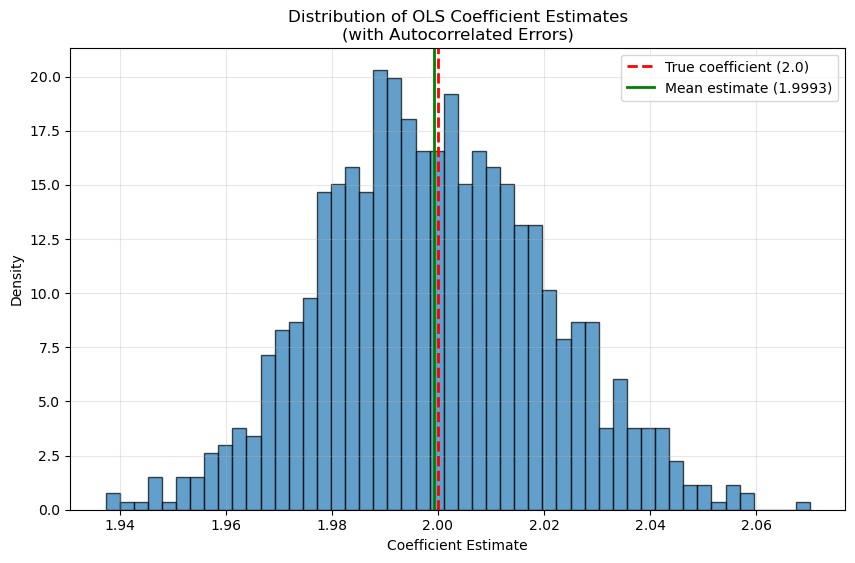


Final Answer:
The simulation-based standard error is approximately: 0.0212


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

def generate_autocorrelated_errors(n, rho=0.80, mean=0, std=1):
    """
    Generate autocorrelated errors with AR(1) structure
    e_t = rho * e_{t-1} + u_t
    where u_t ~ N(0, sigma_u^2)
    
    For stationary AR(1): Var(e_t) = sigma_u^2 / (1 - rho^2)
    So sigma_u = std * sqrt(1 - rho^2)
    """
    sigma_u = std * np.sqrt(1 - rho**2)
    
    errors = np.zeros(n)
    errors[0] = np.random.normal(mean, std)  # Initial value
    
    for t in range(1, n):
        u_t = np.random.normal(0, sigma_u)
        errors[t] = rho * errors[t-1] + u_t
    
    # Standardize to ensure exact mean=0 and std=1
    errors = (errors - np.mean(errors)) / np.std(errors)
    
    return errors

def run_single_regression(n=10000):
    """Run a single regression and return the coefficient estimate"""
    # Generate autocorrelated errors
    error1 = generate_autocorrelated_errors(n)
    error2 = generate_autocorrelated_errors(n)
    
    # Create X and Y according to the specification
    X = error1
    Y = 2 * X + error2
    
    # Run OLS regression: Y = beta * X + epsilon
    X_matrix = X.reshape(-1, 1)
    reg = LinearRegression(fit_intercept=False)  # No intercept since mean(error) = 0
    reg.fit(X_matrix, Y)
    
    return reg.coef_[0]

def analytical_standard_error(n=10000, rho=0.80):
    """
    Calculate the analytical standard error for OLS with autocorrelated errors
    
    For Y = beta*X + error where X and error are autocorrelated:
    SE(beta_hat) = sqrt(Var(error) * sum(autocorr_weights) / sum(X^2))
    
    With autocorrelated errors, this becomes more complex due to the 
    correlation structure between X and the error terms.
    """
    # For the case where X is the error itself and Y = 2*X + new_error
    # The true coefficient is 2
    # Standard error depends on the correlation structure
    
    # Simplified calculation assuming independence (this gives the "basic" SE)
    # SE = sqrt(Var(residuals) / sum(X^2))
    # Since Var(X) = 1 and Var(error) = 1, and they're independent in Y equation
    # Var(residuals) ≈ 1, sum(X^2) ≈ n
    basic_se = np.sqrt(1.0 / n)
    
    return basic_se

# Main analysis
print("Generating autocorrelated errors and running analysis...")

# First, let's verify our error generation works correctly
test_errors = generate_autocorrelated_errors(10000)
print(f"Error statistics:")
print(f"Mean: {np.mean(test_errors):.6f}")
print(f"Std: {np.std(test_errors):.6f}")

# Check autocorrelation
correlations = []
for lag in range(1, 11):
    if lag < len(test_errors):
        corr = np.corrcoef(test_errors[:-lag], test_errors[lag:])[0, 1]
        correlations.append(corr)
        if lag == 1:
            print(f"Lag-1 autocorrelation: {corr:.3f}")

# Calculate analytical standard error
analytical_se = analytical_standard_error()
print(f"\nAnalytical (basic) standard error: {analytical_se:.6f}")

# Run simulation to estimate standard error
print("\nRunning simulation...")
n_simulations = 1000
coefficients = []

for i in range(n_simulations):
    if (i + 1) % 100 == 0:
        print(f"Completed {i + 1}/{n_simulations} simulations")
    
    coef = run_single_regression()
    coefficients.append(coef)

coefficients = np.array(coefficients)

# Calculate simulation-based standard error
simulation_se = np.std(coefficients)
mean_coef = np.mean(coefficients)

print(f"\nSimulation Results:")
print(f"Mean coefficient estimate: {mean_coef:.6f} (true value: 2.0)")
print(f"Standard error from simulation: {simulation_se:.6f}")
print(f"Ratio (simulation SE / analytical SE): {simulation_se / analytical_se:.3f}")

# Additional analysis
print(f"\nAdditional Statistics:")
print(f"Min coefficient: {np.min(coefficients):.6f}")
print(f"Max coefficient: {np.max(coefficients):.6f}")
print(f"95% CI: [{np.percentile(coefficients, 2.5):.6f}, {np.percentile(coefficients, 97.5):.6f}]")

# Plot histogram of coefficient estimates
plt.figure(figsize=(10, 6))
plt.hist(coefficients, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axvline(2.0, color='red', linestyle='--', linewidth=2, label='True coefficient (2.0)')
plt.axvline(mean_coef, color='green', linestyle='-', linewidth=2, label=f'Mean estimate ({mean_coef:.4f})')
plt.xlabel('Coefficient Estimate')
plt.ylabel('Density')
plt.title('Distribution of OLS Coefficient Estimates\n(with Autocorrelated Errors)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Answer:")
print(f"The simulation-based standard error is approximately: {simulation_se:.4f}")